<a href="https://colab.research.google.com/github/yingzibu/JAK_ML/blob/main/notebooks/train_cls_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### train classification single task demo

For classification tasks,
* Scaling dataset is not necessary

For single tasks:
* Assigning different weight to different tasks is not necessary

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu118
cuda:  True


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet
! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

### Code

In [1]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [2]:
# test scripts.func_utils.py

from scripts.func_utils import make_path, convert_with_qed_sa, get_min, \
                                plot_loss, plot_performance

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *
import yaml
import pandas as pd
from scripts.get_vocab import *

from tdc.single_pred import ADME
from tdc.single_pred import Tox
from scripts.CONSTANT import *
from scripts.yaml_utils import *

print('VOCAB TYPE:', VOCAB_TYPE)

VOCAB TYPE: smiles


In [3]:
in_dim = 256
hid_dims = [128, 64, 16]
dropout = 0.3
lr = 3e-4
wd = 1e-5
MAX_EPOCH = 1000
patience = 30           # stop if loss no decrease after epochs # patience
verbose_frequency = 100 # print evaluation every # verbose_frequency epoch
batch_size = 128

# special for AttentiveFP
graph_feat_size = 300
n_layers = 5
num_timesteps = 1   # times of updating the graph representations with GRU

# special for GIN: pretrain model types for selection:
pre_models_GIN = ['gin_supervised_contextpred', 'gin_supervised_infomax',
                     'gin_supervised_edgepred', 'gin_supervised_masking']
pre_model_num = 0    # choose from pre_models for GIN


# if VOCAB_TYPE == 'smiles':
import yaml
def load_vocab(VOCAB_TYPE):
    try:
        with open(f'vocab/{VOCAB_TYPE}.yml', 'r') as f: data = yaml.safe_load(f)
        vocab = data['vocab']; assert VOCAB_TYPE == data['vocab_type']
    except: vocab = None
    return vocab

# special for RNN:
VOCAB = load_vocab(VOCAB_TYPE)
Bid = True
GRU_num_layers = 3
GRU_dim = 256

scale_dict = None
uw = False # uncertainty weight

def get_config(model_type, names,
               pre_model_num=pre_model_num, scale_dict=scale_dict):
    """
    Get config to initialize model
        param model_type: str, ['MLP', 'AttentiveFP', 'GIN', 'RNN']
        param names: list, task names
        param scale_dict: dict,
            if the task is regression, could scale label values
                            {name: [value_min, value_max], ...}
        param pre_model_num: int, [0, 1, 2, 3]
            if model_type is 'GIN', 4 types of pretrained models to choose from
    Returns config that could be used as PRED(**config)
    """
    pre_models_GIN = ['gin_supervised_contextpred', 'gin_supervised_infomax',
                         'gin_supervised_edgepred', 'gin_supervised_masking']

    # print(scale_dict)
    if isinstance(names, str): names = [names]
    IS_R = [names_dict[name] for name in names]
    config_MLP = {'model_type': 'MLP',
            'in_dim': 167,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': f'ckpt_MLP.pt',
            'scale_dict': scale_dict}

    config_ATF = {'model_type': 'AttentiveFP',
            'graph_feat_size': graph_feat_size,
            'num_timesteps': num_timesteps,
            'n_layers': n_layers,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': 'ckpt_AT.pt',
            'scale_dict': scale_dict}

    config_GIN = {'model_type': 'GIN',
            'pretrain_model': pre_models_GIN[pre_model_num],
            'in_dim': in_dim,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'batch_size': batch_size,
            'IS_R': IS_R,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': f'ckpt_GIN_{pre_models_GIN[pre_model_num]}.pt',
            'scale_dict': scale_dict}

    config_RNN = {'model_type': 'RNN',
              'vocab': VOCAB,
              'vocab_type': VOCAB_TYPE,
              'Bidirect': Bid,
              'num_layers': GRU_num_layers,
              'GRU_dim': GRU_dim,
              'out_dim': len(names),
              'prop_names': names,
              'dropout': dropout,
              'IS_R': IS_R,
              'device': 'cuda',
              'batch_size': batch_size,
              'lr': lr,
              'wd': wd,
              'patience': patience,
              'verbose_freq': verbose_frequency,
              'model_path': f'ckpt_RNN_{VOCAB_TYPE}.pt',
              'scale_dict': scale_dict}

    if model_type == 'MLP':           con_MO = config_MLP
    elif model_type == 'AttentiveFP': con_MO = config_ATF
    elif model_type == 'GIN':         con_MO = config_GIN
    elif model_type == 'RNN':         con_MO = config_RNN
    else: print('Error !{MLP, AttentiveFP, GIN, RNN}'); return None

    con_MO['config_path'] = con_MO['model_path'].split('.')[0] + '.yml'
    # different weight of task, initial weight the same
    con_MO['weight_loss'] = [float(1.0)] * len(names)
    con_MO['MAX_EPOCH'] = MAX_EPOCH
    con_MO['uncertainty_weight'] = uw
    return con_MO


In [4]:

def train_cls_st(name, model_type, folder_name, repeat_time, retrain):
    """
    Aim: train classification task, single task
    param
        name:        str, name of task
        model_type:  str, model type
        folder_name: str, the dir of saved model and yml files
        repeat_time: int, repeat training the same model several times
        retrain:     bool,
                     if False, will check whether there exists pretrained
                     else:     retrain anyway and delete past files
    Return a list, each element is a dict, contain performance and train loss
    """
    run_type = 'ST' # single classification task
    make_path(folder_name, False)
    perfs = []
    trn, val, tst = collect_data(name) # no need to scale task
    config = get_config(model_type, name)
    trn_l, val_l, tst_l, vocab = get_multi_loader(trn, val, tst, config)

    if vocab != None and config['vocab'] == None:
        config['vocab'] = vocab # update config vocab info
        print('RNN, no vocab provided, update vocab using dataset | ', end="")
        print('vocab length updated:', len(vocab))

    for i in range(repeat_time):
        print(f'\nRun # {i} for {model_type} {run_type}', end='\t')
        save_dir = f'{folder_name}/{model_type}_{run_type}_{i}'
        print(' | save dir: ', save_dir)
        config['model_path']  = save_dir + '.pt'
        config['config_path'] = save_dir + '.yml'
        config['uncertainty_weight'] = False # single task, no need uw
        config['verbose_freq'] = 100
        config['patience'] = 30
        nofile = False
        if retrain == False:
            try: # try open yml file, if file exists, and no need train
                with open(config['config_path'], 'r') as f: data = yaml.safe_load(f)
                if data != None: p = yml_report(data); print('--> pre data loaded')
                nofile = False
            except:  nofile = True # model was not trained yet, train the model
        if nofile or retrain:
            models = PRED(**config)
            p = models.train(trn_l, val_l, tst_l)

        eval_perf_list(p, name, {}); perfs.append(p)

    eval_perf_list(perfs, name)
    return perfs


Found local copy...
Loading...
Done!


collect data for:  ['HIA_Hou']
---> loader for ['HIA_Hou']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED

Run # 0 for MLP ST	 | save dir:  temp/MLP_ST_0
Model type:  MLP | Model parameters:  30817
Start training MLP...
Epoch:0 [Train] Loss: 3.209 | [Valid] Loss: 0.795	SAVE MODEL: loss: inf -> 0.795 | runtime: 0.178 ms
Epoch:1 [Train] Loss: 3.133 | [Valid] Loss: 0.777	SAVE MODEL: loss: 0.795 -> 0.777 | runtime: 0.174 ms
Epoch:2 [Train] Loss: 3.079 | [Valid] Loss: 0.758	SAVE MODEL: loss: 0.777 -> 0.758 | runtime: 0.176 ms
Epoch:3 [Train] Loss: 2.986 | [Valid] Loss: 0.740	SAVE MODEL: loss: 0.758 -> 0.740 | runtime: 0.168 ms
Epoch:4 [Train] Loss: 2.909 | [Valid] Loss: 0.723	SAVE MODEL: loss: 0.740 -> 0.723 | runtime: 0.202 ms
Epoch:5 [Train] Loss: 2.874 |

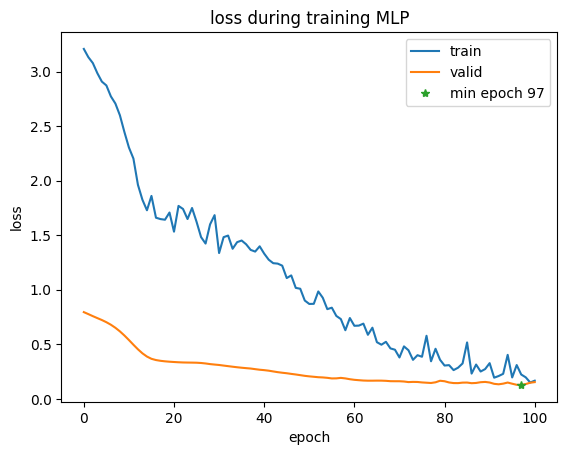

*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.948  &  0.824  &          0.962  &     0.981  &0.667  &0.971 &0.978 &   0.703 &   0.997

Epoch:101 [Train] Loss: 0.153 | [Valid] Loss: 0.150	EarlyStopping counter: 4 out of 30
Epoch:102 [Train] Loss: 0.134 | [Valid] Loss: 0.148	EarlyStopping counter: 5 out of 30
Epoch:103 [Train] Loss: 0.156 | [Valid] Loss: 0.151	EarlyStopping counter: 6 out of 30
Epoch:104 [Train] Loss: 0.145 | [Valid] Loss: 0.158	EarlyStopping counter: 7 out of 30
Epoch:105 [Train] Loss: 0.112 | [Valid] Loss: 0.166	EarlyStopping counter: 8 out of 30
Epoch:106 [Train] Loss: 0.138 | [Valid] Loss: 0.170	EarlyStopping counter: 9 out of 30
Epoch:107 [Train] Loss: 0.132 | [Valid] Loss: 0.162	EarlyStopping counter: 10 out of 30
Epoch:108 [Train] Loss: 0.113 | [Valid] Loss: 0.160	EarlyStopping counter: 11 out of 30
Epoch:109 [Train] Loss: 0.113 | [Valid] Loss: 0.165	EarlyStopping counter: 12 ou

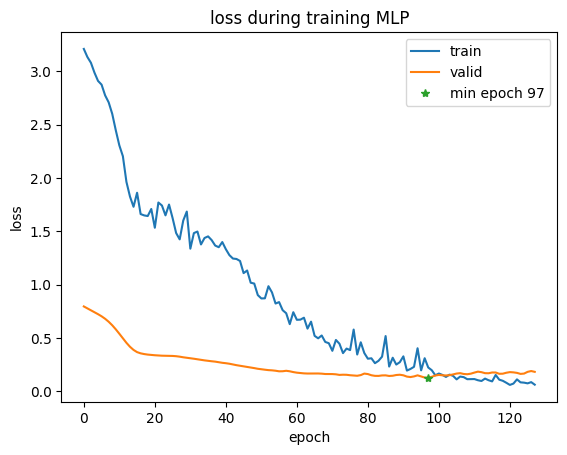

load pretrained model from  temp/MLP_ST_0.pt
[Test] Loss: 0.148
*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.948  &  0.884  &          0.960  &     0.979  &0.789  &0.969 &0.974 &   0.805 &   0.995


--> Train status saved at temp/MLP_ST_0.yml
Finished training

******************** HIA_Hou ******************** 
		 acc 	 	 w_acc 	 	 prec 	 	 recall 	 	 sp 	 	 f1 	 	 auc 	 	 mcc 	 	 ap 	 
	| 0.948 +/- 0.000 | 0.884 +/- 0.000 | 0.960 +/- 0.000 | 0.979 +/- 0.000 | 0.789 +/- 0.000 | 0.969 +/- 0.000 | 0.974 +/- 0.000 | 0.805 +/- 0.000 | 0.995 +/- 0.000 | 


Run # 1 for MLP ST	 | save dir:  temp/MLP_ST_1
Model type:  MLP | Model parameters:  30817
Start training MLP...
Epoch:0 [Train] Loss: 2.829 | [Valid] Loss: 0.696	SAVE MODEL: loss: inf -> 0.696 | runtime: 0.179 ms
Epoch:1 [Train] Loss: 2.766 | [Valid] Loss: 0.680	SAVE MODEL: loss: 0.696 -> 0.680 | runtime: 0.193 ms
Epoch:2 [Train] Loss: 2.692 | [Valid]

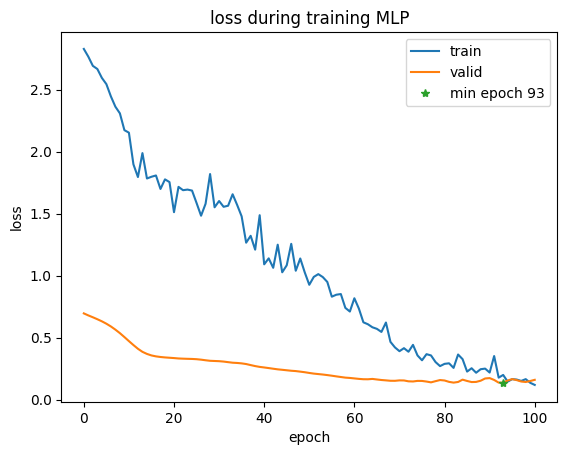

*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.948  &  0.824  &          0.962  &     0.981  &0.667  &0.971 &0.981 &   0.703 &   0.998

Epoch:101 [Train] Loss: 0.151 | [Valid] Loss: 0.163	EarlyStopping counter: 8 out of 30
Epoch:102 [Train] Loss: 0.112 | [Valid] Loss: 0.150	EarlyStopping counter: 9 out of 30
Epoch:103 [Train] Loss: 0.132 | [Valid] Loss: 0.141	EarlyStopping counter: 10 out of 30
Epoch:104 [Train] Loss: 0.151 | [Valid] Loss: 0.143	EarlyStopping counter: 11 out of 30
Epoch:105 [Train] Loss: 0.104 | [Valid] Loss: 0.158	EarlyStopping counter: 12 out of 30
Epoch:106 [Train] Loss: 0.118 | [Valid] Loss: 0.166	EarlyStopping counter: 13 out of 30
Epoch:107 [Train] Loss: 0.165 | [Valid] Loss: 0.156	EarlyStopping counter: 14 out of 30
Epoch:108 [Train] Loss: 0.100 | [Valid] Loss: 0.143	EarlyStopping counter: 15 out of 30
Epoch:109 [Train] Loss: 0.097 | [Valid] Loss: 0.146	EarlyStopping counter: 1

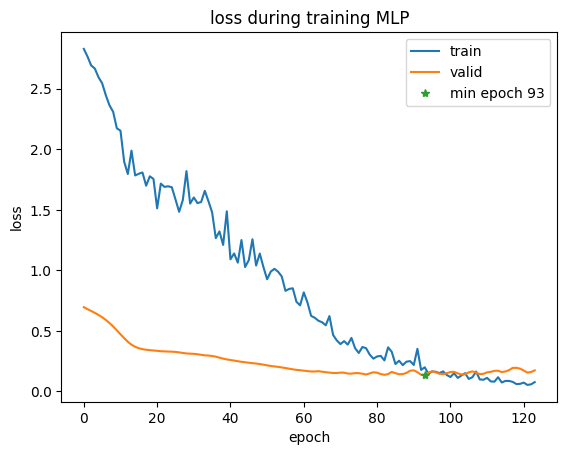

load pretrained model from  temp/MLP_ST_1.pt
[Test] Loss: 0.157
*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.948  &  0.884  &          0.960  &     0.979  &0.789  &0.969 &0.969 &   0.805 &   0.994


--> Train status saved at temp/MLP_ST_1.yml
Finished training

******************** HIA_Hou ******************** 
		 acc 	 	 w_acc 	 	 prec 	 	 recall 	 	 sp 	 	 f1 	 	 auc 	 	 mcc 	 	 ap 	 
	| 0.948 +/- 0.000 | 0.884 +/- 0.000 | 0.960 +/- 0.000 | 0.979 +/- 0.000 | 0.789 +/- 0.000 | 0.969 +/- 0.000 | 0.969 +/- 0.000 | 0.805 +/- 0.000 | 0.994 +/- 0.000 | 


Run # 2 for MLP ST	 | save dir:  temp/MLP_ST_2
Model type:  MLP | Model parameters:  30817
Start training MLP...
Epoch:0 [Train] Loss: 2.881 | [Valid] Loss: 0.705	SAVE MODEL: loss: inf -> 0.705 | runtime: 0.181 ms
Epoch:1 [Train] Loss: 2.795 | [Valid] Loss: 0.682	SAVE MODEL: loss: 0.705 -> 0.682 | runtime: 0.199 ms
Epoch:2 [Train] Loss: 2.699 | [Valid]

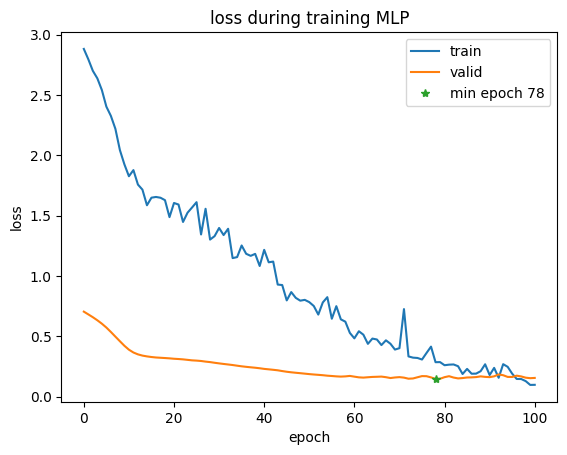

*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.948  &  0.824  &          0.962  &     0.981  &0.667  &0.971 &0.981 &   0.703 &   0.998

Epoch:101 [Train] Loss: 0.115 | [Valid] Loss: 0.159	EarlyStopping counter: 23 out of 30
Epoch:102 [Train] Loss: 0.114 | [Valid] Loss: 0.160	EarlyStopping counter: 24 out of 30
Epoch:103 [Train] Loss: 0.100 | [Valid] Loss: 0.160	EarlyStopping counter: 25 out of 30
Epoch:104 [Train] Loss: 0.099 | [Valid] Loss: 0.169	EarlyStopping counter: 26 out of 30
Epoch:105 [Train] Loss: 0.086 | [Valid] Loss: 0.173	EarlyStopping counter: 27 out of 30
Epoch:106 [Train] Loss: 0.092 | [Valid] Loss: 0.175	EarlyStopping counter: 28 out of 30
Epoch:107 [Train] Loss: 0.087 | [Valid] Loss: 0.174	EarlyStopping counter: 29 out of 30
Epoch:108 [Train] Loss: 0.089 | [Valid] Loss: 0.174	EarlyStopping counter: 30 out of 30
early stop

--> Train status saved at temp/MLP_ST_2.yml
task weight ['1.00

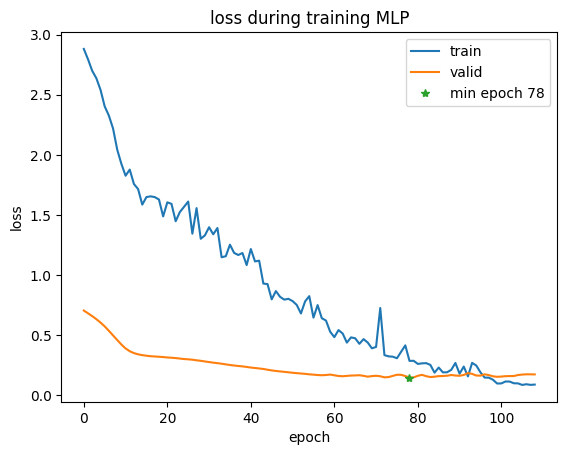

load pretrained model from  temp/MLP_ST_2.pt
[Test] Loss: 0.154
*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,      F1,     AUC,     MCC,     AP
& 0.948  &  0.884  &          0.960  &     0.979  &0.789  &0.969 &0.971 &   0.805 &   0.994


--> Train status saved at temp/MLP_ST_2.yml
Finished training

******************** HIA_Hou ******************** 
		 acc 	 	 w_acc 	 	 prec 	 	 recall 	 	 sp 	 	 f1 	 	 auc 	 	 mcc 	 	 ap 	 
	| 0.948 +/- 0.000 | 0.884 +/- 0.000 | 0.960 +/- 0.000 | 0.979 +/- 0.000 | 0.789 +/- 0.000 | 0.969 +/- 0.000 | 0.971 +/- 0.000 | 0.805 +/- 0.000 | 0.994 +/- 0.000 | 

repeated num # 3 idx 0 has the lowest loss from [0.1479334980249405, 0.15669384598731995, 0.15392181277275085]
******************** HIA_Hou ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.948 +/- 0.000 | 0.969 +/- 0.000 | 0.971 +/- 0.002 | 
 idx 0: | 0.948 +/- 0.000 | 0.969 +/- 0.000 | 0.974 +/- 0.000 | 



In [12]:
# train 'HIA_Hou' task, using MLP, train 3 times, save files at temp/
name = 'HIA_Hou'
model_type = 'MLP'
perfs = train_cls_st(name, model_type, 'temp', repeat_time=3, retrain=True)

In [10]:
# repeated num # 3 idx 0 has the lowest loss from [0.1479334980249405, 0.15669384598731995, 0.15392181277275085]
# ******************** HIA_Hou ********************
# 		 acc 	 	 f1 	 	 auc
# 	| 0.948 +/- 0.000 | 0.969 +/- 0.000 | 0.971 +/- 0.002 |
#  idx 0: | 0.948 +/- 0.000 | 0.969 +/- 0.000 | 0.974 +/- 0.000 |
# idx 0 means the in the 3 repeat times, the 0th model has the lowest test loss

idx = 0
yml_name = f'temp/{model_type}_ST_{idx}.yml'
print(yml_name)
p1 = yml_report(yml_name, ver=False)
eval_perf_list(p1, 'HIA_Hou', d)


temp/MLP_ST_0.yml
******************** HIA_Hou ******************** 
	|       acc      |       f1      |       auc      
single: &0.948            &0.969            &0.974            
